# HW9: Forecasting Solar Cycles

Below is the notebook associated with HW\#9. You can run the notebook in two modes. If you have the `emcee` and `corner` packages installed on your machine, along with the data files, just keep the following variable set to `False`. If you are running it in a Google colab notebook, set it to `True` so that it will grab the packages and files. Remember that the Google colab environment will shutdown after ~1 hour of inactivity, so you'll need to keep interacting with it or else will lose the data.

A script version of this file will also be provided to you, but you cannot use this in a Google colab environment

In [1]:
COLAB = False

In [2]:
if COLAB:
    # Install emcee package
    !pip install emcee
    # Install corner package
    !pip install corner    
    # Grab sunspot data file
    !wget -O SN_m_tot_V2.0.txt https://raw.githubusercontent.com/mtlam/ASTP-720_F2020/master/HW9/SN_m_tot_V2.0.txt

In [2]:
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
#import sys
#!{sys.executable} -m pip install corner
import emcee
import corner
%matplotlib inline

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

## Define the (log-)priors

Here, the function should take a vector of parameters, `theta`, and return `0.0` if the it is in the prior range and `-np.inf` if it is outside. This is equivalent to a uniform prior over the parameters. You can, of course, define a different set of priors if you so choose!

In [3]:
def lnprior(theta):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
        
    Returns
    -------
    Value of log-prior.    
    """
    retval = 0.0
    for i in range(len(theta)):
        if np.abs(theta[i]) > 1.0:
            retval = -np.inf
    return(retval)

## Define the (log-)likelihood

In [4]:
def lnlike(theta, data):
    """
    Parameters
    ----------
    theta : np.ndarray
        Array of parameters.
    data : np.ndarray
        
        
    Returns
    -------
    Value of log-likelihood   
    """
    residuals = 0
    for j in range(1, len(data)):
        Z1 = theta[0]*data[j-1]
        if j > 11:
            Z2 = theta[1]*data[j-12]
        else:
            Z2 = 0
        if j > 130:
            Z3 = theta[2]*data[j-131]
        else:
            Z3 = 0
        paramtot = Z1+Z2+Z3
        diff = data[j] - paramtot
        residuals += paramtot**2
    return(np.log(residuals))

## Define total (log-)probability

No need to change this if the other two functions work as described.

In [5]:
def lnprob(theta, data):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data)

## Set up the MCMC sampler here

In [6]:
# Number of walkers to search through parameter space
nwalkers = 10
# Number of iterations to run the sampler for
niter = 50000
# Initial guess of parameters. For example, if you had a model like
# s(t) = a + bt + ct^2
# and your initial guesses for a, b, and c were 5, 3, and 8, respectively, then you would write
# pinit = np.array([5, 3, 8])
# Make sure the guesses are allowed inside your lnprior range!
pinit = np.array([0.6, 0.4, 0.7])
# Number of dimensions of parameter space
ndim = len(pinit)
# Perturbed set of initial guesses. Have your walkers all start out at
# *slightly* different starting values
p0 = [pinit + 1e-4*pinit*np.random.randn(ndim) for i in range(nwalkers)]

## Load the data, plot to show

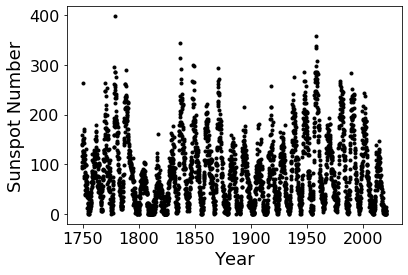

In [7]:
# Data: decimal year, sunspot number
decyear, ssn = np.loadtxt("SN_m_tot_V2.0.txt", unpack=True, usecols=(2, 3))
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
show()

## Run the sampler

In [8]:
# Number of CPU threads to use. Reduce if you are running on your own machine
# and don't want to use too many cores
nthreads = 4
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(ssn,), threads=nthreads)
# Run the sampler. May take a while! You might consider changing the 
# number of iterations to a much smaller value when you're testing. Or use a 
# larger value when you're trying to get your final results out!
sampler.run_mcmc(p0, niter, progress=True)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [32:51<00:00, 25.36it/s]


State([[-0.56726416 -0.91749957 -0.35131302]
 [-0.08894102  0.92212269  0.37085421]
 [-0.18690151  0.77261706  0.51379478]
 [ 0.23439098  0.52420976  0.02813877]
 [-0.76707548 -0.37134743 -0.80644576]
 [ 0.42166433  0.97141122  0.20734226]
 [-0.45960026 -0.98273176 -0.81448413]
 [ 0.59016328  0.58299271 -0.37480662]
 [ 0.95268511 -0.71493264  0.54275587]
 [-0.84105011 -0.47535344 -0.9089934 ]], log_prob=[18.54170768 17.71869458 17.53324974 16.88706943 18.63669344 18.28345424
 18.93544791 17.10998153 17.07362117 18.90530294], blobs=None, random_state=('MT19937', array([ 417193924, 3922548174,    9060087, 3518920510, 3675803248,
       3346112524, 3753454749, 3830866472, 1238580505, 3346375932,
        559891428, 3609758598, 1884091480,  364745738, 3632464007,
       1457496652, 1331980168, 1184853777,  357217690, 3728219480,
       3986630188,  791991713, 1106988617, 1303736336, 1447483782,
       1560977216, 3929852768, 1056615676,  590548388, 4239068478,
        532638840,  771651497,

## Get the samples in the appropriate format, with a burn value

In [9]:
# Burn-in value = 1/4th the number of iterations. Feel free to change!
burn = int(0.25*niter)
# Reshape the chains for input to corner.corner()
samples = sampler.chain[:, burn:, :].reshape((-1, ndim))

## Make a corner plot

You should feel free to adjust the parameters to the `corner` function. You **should** also add labels, which should just be a list of the names of the parameters. So, if you had two parameters, $\phi_1$ and $\phi_2$, then you could write:

```
labels = [r"$\phi_1$", r"$\phi_2$"]
```

and that will make the appropriate label in LaTeX (if the distribution is installed correctly) for the two 1D posteriors of the corner plot.

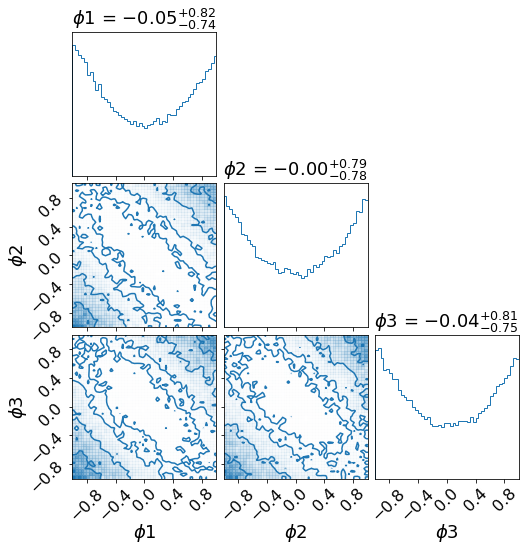

In [10]:
labels = [r'$\phi1$', r'$\phi2$', r'$\phi3$']
fig = corner.corner(samples, bins=50, color='C0', smooth=0.5, plot_datapoints=False, plot_density=True, \
                    plot_contours=True, fill_contour=False, show_titles=True, labels=labels)
fig.savefig("corner.png")
show()

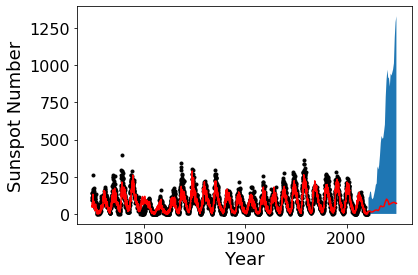

In [55]:
plot(decyear, ssn, 'k.')
xlabel('Year')
ylabel('Sunspot Number')
#show()
Xt = []
newtime = []
lowerr = []
higherr = []
future = 2050 - decyear[-1]
predict = int(np.round(future/0.81))
for i in range(1, len(ssn)+predict):
    if i > len(ssn):
        Z1 = -0.05*Xt[i-2]
        sampletime = newtime[-1] + 0.81
        newtime.append(sampletime)
        low = 0.77*Xt[i-2]
        high = -0.79*Xt[i-2]
    else:
        Z1 = -0.05*ssn[i-1]
        newtime.append(decyear[i-1])
    if i > len(ssn)+11:
        Z2 = -0.001*Xt[i-13]
        low += 0.79*Xt[i-13]
        high += -0.78*Xt[i-13]
    else:
        if i > 11:
            Z2 = -0.001*ssn[i-12]
        else:
            Z2 = 0
    if i > len(ssn)+130:
        Z3 = -0.04*Xt[i-132]
        low += 0.77*Xt[i-132]
        high += -0.79*Xt[i-132]
    else:
        if i > 130:
            Z3 = -0.04*ssn[i-131]
        else:
            Z3 = 0
    tot = Z1+Z2+Z3
    Xt.append(-10*tot)
    if i > len(ssn):
        lowerr.append(0)
        higherr.append(-10*high)
plot(newtime, Xt, 'r')
fill_between(newtime[-35:], lowerr, higherr)